In [1]:
import os
import requests
from ipyleaflet import Map, DrawControl, basemaps, TileLayer
import rasterio
import matplotlib.pyplot as plt
import rioxarray as rio
import numpy as np
from osgeo import gdal, osr
from matplotlib.colors import LinearSegmentedColormap
import pyproj
from pyproj import CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info

## 0. Handling your API key

We recommend storing your OT API key in a environment variable. This prevents keys from being hardcoded in the source code, reducing the risk of exposure through sharing or version control. It also enhances flexibility, allowing the same code to be used in various environments without changes. Below are the steps to take to store your API key in an environment variable.  

### For Linux/macOS  

Open up a Terminal window and find your shell's profile script. For Bash, you might find '~ /.bashrc' or '~ /.bash_profile'.
For Zsh, you might find '~ /.zshrc'.  

```cd ~```  
```ls -a```  

Once you know the name of your shell’s profile script, you can edit it using a text editor that operates in the terminal (like ```nano``` or ```vim```) or out side the terminal with the text editor of your choosing. This example will use '~/.zshrc' as the name of the shell profile script and ```nano``` as the text editor. If the file is read-only, you might need to use ```sudo``` to edit it.  

```nano ~/.zshrc```  

At the end of the .zshrc file, add a line to define your environment variable. 'your_api_key_here' is a stand in for the alphanumeric API key accessible at [MyOpenTopo](https://portal.opentopography.org/myopentopo) under "Get an API Key."   
 
```export OPENTOPOGRAPHY_API_KEY='your_api_key_here'```


Exit (```control + X``` for ```nano```) and save (```Y``` to ```Save modified buffer (ANSWERING "No" WILL DESTROY CHANGES) ?``` then ```Enter``` for ```nano```).

For your changes to take effect, you need to reload the .zshrc file or restart your terminal. To reload .zshrc without restarting, type the following command in your terminal and press Enter:  

```source ~/.zshrc```  

This will make the OPENTOPOGRAPHY_API_KEY environment variable available in all new terminal sessions.  

Make sure to open the notebook from the Terminal (navigating to the project directory and typing ```jupyter lab``` or ```jupyter notebook```), ensuring it inherits the Terminal's environment variables.

### For Windows  

1. Search for "Environment Variables" in the Start menu.
1. Click on "Edit the system environment variables."
1. In the System Properties window, click on "Environment Variables."
1. Click on "New" under System variables or User variables depending on your need.
1. Set "Variable name" as OPENTOPOGRAPHY_API_KEY and "Variable value" as your actual API key. Your alphanumeric API key is accessible at [MyOpenTopo](https://portal.opentopography.org/myopentopo) under "Get an API Key."
1. Click OK and apply the changes.


## 1. Define area of interest 

### Option 1: Define bounds manually

In [ ]:
# Initialize global variables to store bounding box coordinates
global_bounds = {'south': 0, 'north': 0, 'west': 0, 'east': 0}

#Manually enter bounding box coordinates (WGS 84)
global_bounds['south'] = 39.24382
global_bounds['west'] = -105.387354
global_bounds['north'] = 39.294853
global_bounds['east'] = -105.219782

#Skip the rest of the cells in step 1 and proceed to step 2. 

### Option 2: Use a shapefile

In [ ]:
# Initialize global variables to store bounding box coordinates
global_bounds = {'south': 0, 'north': 0, 'west': 0, 'east': 0}

# Path to your shapefile
shapefile_path = 'path/to/your/shapefile.shp'

# Load the shapefile
gdf = gpd.read_file(shapefile_path)

# Get the overall bounds of the shapefile
overall_bounds = gdf.total_bounds  # Returns [minx, miny, maxx, maxy]

# Update global_bounds with the shapefile's bounding box
global_bounds['west'], global_bounds['south'], global_bounds['east'], global_bounds['north'] = overall_bounds

#Skip the rest of the cells in step 1 and proceed to step 2.

### Option 3: Draw a bounding box on an interactive map

In [69]:
# Initialize global variables to store bounding box coordinates
global_bounds = {'south': 0, 'north': 0, 'west': 0, 'east': 0}
def handle_draw(self, action, geo_json):
    # Extract the bounding box coordinates from the drawn rectangle
    coords = geo_json['geometry']['coordinates'][0]
    global_bounds['south'] = coords[0][1]
    global_bounds['west'] = coords[0][0]
    global_bounds['north'] = coords[2][1]
    global_bounds['east'] = coords[2][0]
    
    print(f"Bounds updated: {global_bounds}")

# Initialize the map
m = Map(center=(39.8283, -98.5795), zoom=3, basemap=basemaps.Esri.WorldTopoMap)

# Set up the drawing tool
draw_control = DrawControl(rectangle={'shapeOptions': {'color': '#fca45d'}})
draw_control.polyline = {}
draw_control.polygon = {}
draw_control.circle = {}
draw_control.circlemarker = {}
draw_control.on_draw(handle_draw)
m.add_control(draw_control)

m

Map(center=[39.8283, -98.5795], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

In [70]:
global_bounds

{'south': 39.24382,
 'north': 39.294853,
 'west': -105.387354,
 'east': -105.219782}

## 2. Use OT API to query DEMs

In [71]:
# If you haven't set up your API key as an environment variable in step 0. or the API key has failed to load, you can directly input your API key here, keeping in mind the security implications. 
# If you input you API key here, skip the next cell.
API_Key = 'your_api_key_here'

# If your API key is stored in the environment variable 'OPENTOPOGRAPHY_API_KEY', proceed to the next cell.

In [72]:
# After setting the environment variable, access your API key in this notebook.
API_Key = os.getenv('OPENTOPOGRAPHY_API_KEY')

if API_Key is not None:
    print("API Key loaded successfully!")
else:
    print("Failed to load API Key.")

API Key loaded successfully!


In [73]:
base_url = "https://portal.opentopography.org//API"
endpoint = "/usgsdem"

# Prepare the query parameters using the bounds stored in global_bounds
params = {
    "datasetName": "USGS1m",  # USGS 3DEP raster: USGS1m, USGS10m, USGS30m
    "south": global_bounds['south'], # WGS 84 bounding box south coordinates
    "north": global_bounds['north'], # WGS 84 bounding box north coordinates
    "west": global_bounds['west'], # WGS 84 bounding box west coordinates
    "east": global_bounds['east'], # WGS 84 bounding box east coordinates
    "outputFormat": "GTiff", # Output Format (optional) - GTiff for GeoTiff, AAIGrid for Arc ASCII Grid, HFA for Erdas Imagine (.IMG). Defaults to GTiff if parameter is not provided
    "API_Key": API_Key,
}

# Make the GET request to the API
response = requests.get(url=base_url + endpoint, params=params)

# Check if the request was successful
if response.status_code == 200:
    filename = 'output.tif' 
    with open(filename, 'wb') as file:
        file.write(response.content)
    print(f"File has been saved as '{filename}'.")
else:
    print(f"Error: {response.status_code}")

File has been saved as 'output.tif'.


## 3. Generate visualization products

### Show DEM

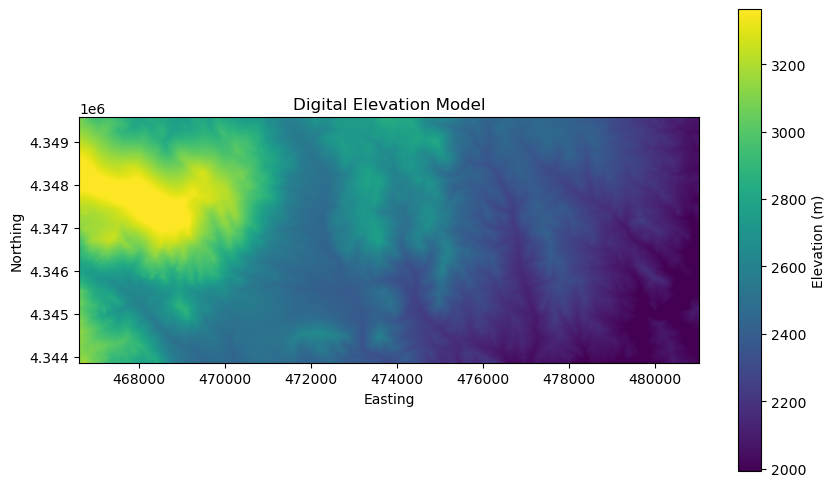

In [74]:
# Replace 'your_dem_file.tif' with the path to your DEM file
dem_file = 'output.tif'

# Open the DEM file
with rasterio.open(dem_file) as dem:
    # Read the entire array
    elevation = dem.read(1)
    
    # Get bounds
    bounds = dem.bounds
    width = dem.width
    height = dem.height
    
    # Calculate longitude and latitude for each pixel
    lon = np.linspace(bounds.left, bounds.right, width)
    lat = np.linspace(bounds.top, bounds.bottom, height)

    vmin, vmax = np.percentile(elevation, 2), np.percentile(elevation, 98)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.imshow(elevation, cmap='viridis', vmin=vmin, vmax=vmax, extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
    plt.colorbar(label='Elevation (m)')
    plt.title('Digital Elevation Model')
    plt.xlabel('Easting')
    plt.ylabel('Northing')
    plt.show()

### Convert geographic coordiantes to UTM coordinates for raster calculations

In [75]:
gdal.UseExceptions()
def warp_raster(input_file, output_file, epsg_code):
    # Example usage:
  input_ds = gdal.Open(input_file)
  input_proj = input_ds.GetProjection()
  source_srs = osr.SpatialReference(input_proj)

  target_srs = f"EPSG:{epsg_code}"
  resampling_method = "bilinear"
  output_format = "GTiff"

  warp_options = gdal.WarpOptions(
  format=output_format,
  srcSRS=source_srs,
  dstSRS=target_srs,
  resampleAlg=resampling_method)

  gdal.Warp(output_file, input_file, options=warp_options)

def native_utm_crs_from_bounds(bounds,datum):
    utm_crs_list = query_utm_crs_info(
        datum_name=datum,
        area_of_interest=AreaOfInterest(
            west_lon_degree=global_bounds['west'],
            south_lat_degree=global_bounds['south'],
            east_lon_degree=global_bounds['east'],
            north_lat_degree=global_bounds['north'],
        ),
    )
    utm_crs = CRS.from_epsg(utm_crs_list[0].code)
    return utm_crs

def geographic_to_utm(input_file, output_file, bounds):
    epsg_code = native_utm_crs_from_bounds(bounds,"WGS84").to_epsg()
    warp_raster(input_file, output_file, epsg_code)

In [76]:
dem_utm_file = "output_utm.tif"
geographic_to_utm(dem_file, dem_utm_file, global_bounds)

### Show hillshade

In [77]:
def calculate_hillshade(input_dem, output_hillshade, azimuth, altitude):
    # Create options dictionary
    options = gdal.DEMProcessingOptions(azimuth=azimuth, altitude=altitude)
    
    # Call DEMProcessing with the options object
    gdal.DEMProcessing(output_hillshade, input_dem, "hillshade", options=options)

# Paths to your input DEM and output hillshade file
hillshade_path = 'output_hillshade.tif'

# Call the function with the DEM file, output path, azimuth, and altitude
calculate_hillshade(dem_utm_file, hillshade_path, 315, 45)

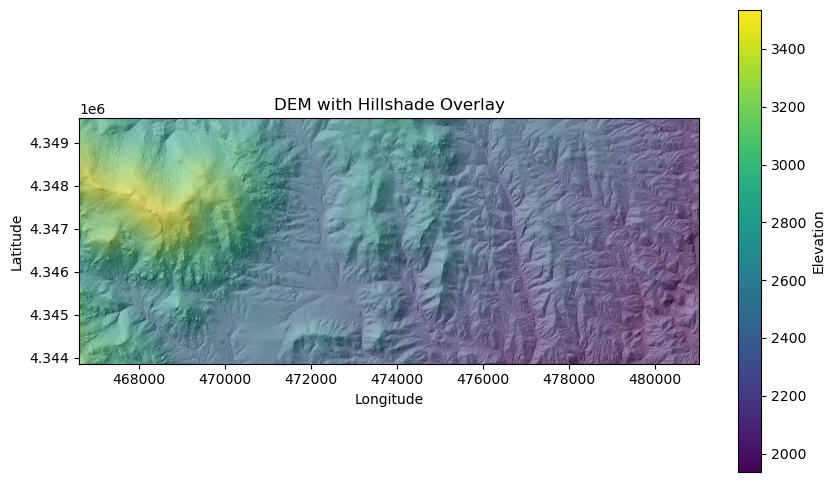

In [78]:
#Load the DEM data
with rasterio.open(dem_utm_file) as dem_data:
    dem = dem_data.read(1)  # Read the first band
    dem_extent = [dem_data.bounds.left, dem_data.bounds.right, dem_data.bounds.bottom, dem_data.bounds.top]

# Load the hillshade data
with rasterio.open(hillshade_path) as hillshade_data:
    hillshade = hillshade_data.read(1)

# Plot the DEM with colormap
plt.figure(figsize=(10, 6))
plt.imshow(elevation, cmap='viridis', extent=dem_extent)
plt.colorbar(label='Elevation')

# Overlay the hillshade with a chosen alpha (transparency level)
plt.imshow(hillshade, cmap='gray', alpha=0.5, extent=dem_extent)  # Ensure the same extent

plt.title('DEM with Hillshade Overlay')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Show slope map

In [79]:
def calculate_slope(input_dem, output_slope):
    gdal.DEMProcessing(output_slope, input_dem, "slope")

slope_path = 'output_slope.tif'
calculate_slope(dem_utm_file, slope_path)

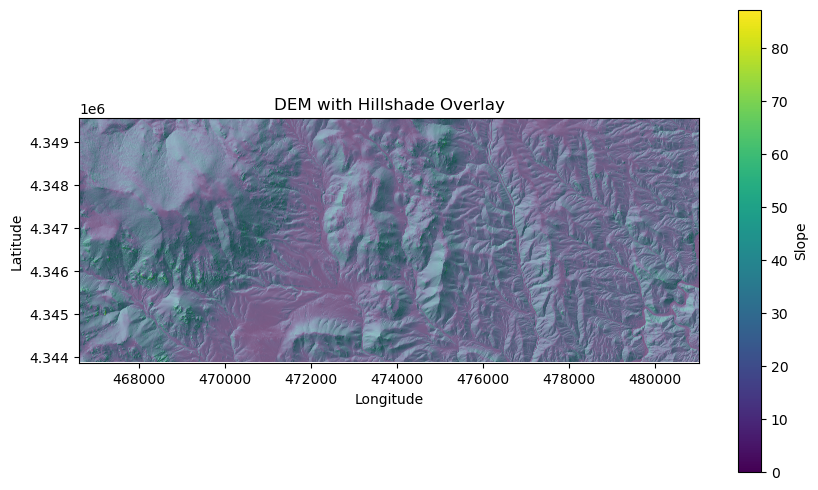

In [80]:
#Load the DEM data
with rasterio.open(slope_path) as slope_data:
    slope = slope_data.read(1, masked=True)  # Read the first band
    slope_extent = [slope_data.bounds.left, slope_data.bounds.right, slope_data.bounds.bottom, slope_data.bounds.top]

# Load the hillshade data
with rasterio.open(hillshade_path) as hillshade_data:
    hillshade = hillshade_data.read(1, masked=True)
    

# Plot the DEM with colormap
plt.figure(figsize=(10, 6))
plt.imshow(slope, cmap='viridis', extent=slope_extent)
plt.colorbar(label='Slope')

# Overlay the hillshade with a chosen alpha (transparency level)
plt.imshow(hillshade, cmap='gray',alpha=0.5, extent=slope_extent)  # Ensure the same extent

plt.title('DEM with Hillshade Overlay')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Show roughness map

In [81]:
def calculate_roughness(input_dem, output_roughness):
    method = 'roughness'
    options = ['-of', 'GTiff', '-b', '1']
    gdal.DEMProcessing(output_roughness, input_dem, method, options=options)

roughness_path = 'output_roughness.tif'
calculate_roughness(dem_utm_file, roughness_path)

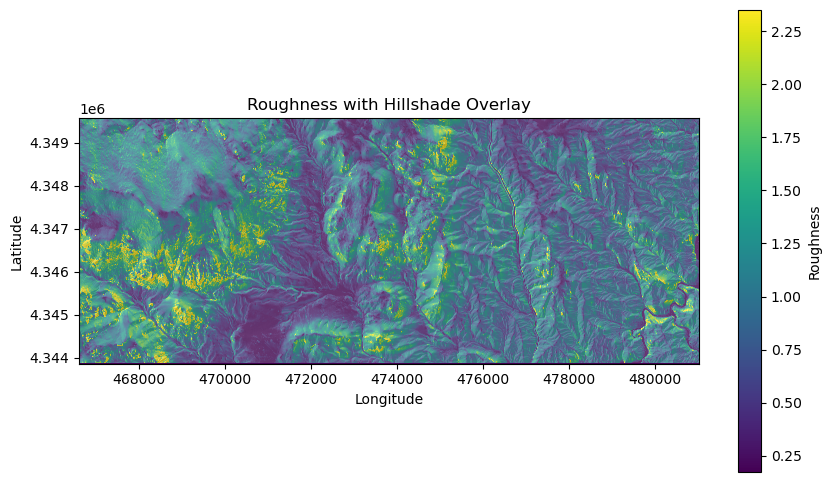

In [91]:
#Load the DEM data
with rasterio.open(roughness_path) as roughness_data:
    roughness = roughness_data.read(1)  # Read the first band
    roughness_extent = [roughness_data.bounds.left, roughness_data.bounds.right, roughness_data.bounds.bottom, roughness_data.bounds.top]

# Load the hillshade data
with rasterio.open(hillshade_path) as hillshade_data:
    hillshade = hillshade_data.read(1, masked=True)
    
vmin = np.percentile(roughness,2)
vmax = np.percentile(roughness,98)

# Plot the DEM with colormap
plt.figure(figsize=(10, 6))
plt.imshow(roughness, cmap='viridis', vmin=vmin, vmax=vmax,  extent=roughness_extent)
plt.colorbar(label='Roughness')

# Overlay the hillshade with a chosen alpha (transparency level)
plt.imshow(hillshade, cmap='gray',alpha=0.3, extent=roughness_extent)  # Ensure the same extent

plt.title('Roughness with Hillshade Overlay')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Show aspect map

In [83]:
def calculate_aspect(input_dem, output_aspect):
    method = 'aspect'
    options = ['-of', 'GTiff', '-zero_for_flat']
    gdal.DEMProcessing(output_aspect, input_dem, method, options=options)

aspect_path = 'output_aspect.tif'
calculate_aspect(dem_utm_file, aspect_path)

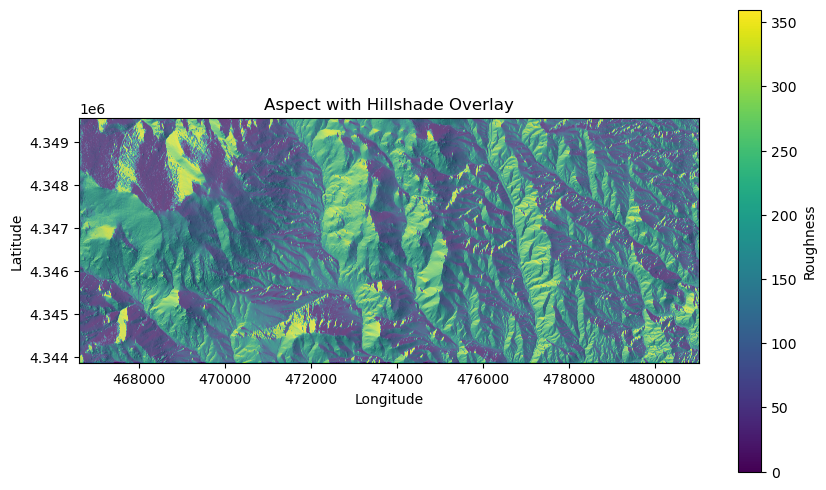

In [90]:
#Load the DEM data
with rasterio.open(aspect_path) as aspect_data:
    aspect = aspect_data.read(1, masked=True)  # Read the first band
    aspect_extent = [aspect_data.bounds.left, aspect_data.bounds.right, aspect_data.bounds.bottom, aspect_data.bounds.top]

# Load the hillshade data
with rasterio.open(hillshade_path) as hillshade_data:
    hillshade = hillshade_data.read(1, masked=True)
    

# Plot the DEM with colormap
plt.figure(figsize=(10, 6))
plt.imshow(aspect, cmap='viridis',  extent=aspect_extent)
plt.colorbar(label='Roughness')

# Overlay the hillshade with a chosen alpha (transparency level)
plt.imshow(hillshade, cmap='gray',alpha=0.3, extent=aspect_extent)  # Ensure the same extent

plt.title('Aspect with Hillshade Overlay')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()